## Описание
#### Необходимо построить алгоритм, который для каждой пары пользователь-услуга определит вероятность подключения услуги.
#### В качестве исходных данных вам будет доступна информация об отклике абонентов на предложение подключения одной из услуг. Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить.
#### Отдельным набором данных будет являться нормализованный анонимизированный набор признаков, характеризующий профиль потребления абонента. Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени.
#### Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test отложен последующий месяц.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
from pathlib import Path

%matplotlib inline
import matplotlib.pyplot as plt

from datetime import datetime, date, time

# Предупреждения и вывод столбцов
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 100

# Импорт моделей
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import catboost

# Для пайплайна
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

# Построение и оценка модели
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Импортируем методы оценки важности фичей
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

import pickle

from utils import reduce_mem_usage, balance_df_by_target, get_classification_report, prepare_df_test, prepare_df_train
from utils import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve, run_grid_search, run_cv, features_types

In [2]:
# Фиксируем RANDOM_STATE
RANDOM_STATE = 42

## 1.1. Загрузка и оптимизация датасета

In [3]:
DATA_ROOT = Path('./data/')

TRAIN_PATH = DATA_ROOT / 'data_train.csv'
TEST_PATH = 'data_test.csv'
DATA_PATH = DATA_ROOT / 'features.csv'

In [4]:
df_train = pd.read_csv(TRAIN_PATH)
df_train.drop('Unnamed: 0', axis=1, inplace=True)
df_train.head(3)

,id,vas_id,buy_time,target
0,540968,8.0,1537131600,0.0
1,1454121,4.0,1531688400,0.0
2,2458816,1.0,1534107600,0.0


In [5]:
df_test = pd.read_csv(TEST_PATH)
df_test.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
%time
data = pd.read_csv(DATA_PATH, sep='\t', index_col=[0])
data.head(3)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 4.77 µs


,id,buy_time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,...,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,-65.076097,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,49.520873,38.19189,-0.000725,-0.016435,-0.107041,-1.17746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.65939,-0.065583,-0.700765,-42.026959,-2841.496068,-1085.821501,-1755.674564,-89.504287,-119.724355,-70.712019,-54.069191,-16.642826,-7.896282,-5.634035,...,0.0,0.039208,0.665644,-0.008999,-11953.712824,-45175.257711,0.377099,-30.716053,-61790.157098,-0.243136,-42051.166127,-9239.707081,-2.10805,-0.000083,0.377104,-0.00004,0.379228,-0.012257,-0.107878,9.595373e+08,-42.014078,-4.405604e+08,1.356414e+09,5.565998,-1.465191,-33.302382,-249.128986,-36.772492,-0.364694,-0.133771,-0.209468,-32.356505,-109.884564,-876.69102,-5.368281,-247.110707,-108.409742,-512.437331,-84.617978,-17.295406,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,-53.216097,-6.783660,-26.544905,-2.736081,-4.007526,-2.558912,67.300873,55.97189,-0.000725,-0.016435,-0.107041,15.77254,-3.178521,411.379185,-10.744164,-0.094251,-0.001733,-0.009327,131.407791,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.65939,-0.065583,-0.700765,-192.026959,-2937.657200,-1181.982633,-1755.674564,447.193953,1258.981645,-119.662019,-54.602524,-65.059494,29.770382,-7.997875,...,0.0,0.039208,-0.334356,-0.008999,-1035.951824,-45175.257711,-0.622901,-30.716053,-61790.157098,0.756864,-39131.166127,-9239.707081,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,9.673997e+08,-39.474078,1.033869e+09,-1.204418e+08,5.232666,-0.465191,-33.302382,38.871014,4.227508,-0.364694,-0.133771,-0.209468,2.643495,-109.884564,-573.69102,3.631719,43.889293,-108.409742,-509.437331,-27.617978,-5.295406,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2015199,1545598800,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,25.183903,-0.417924,-1.689642,-2.736081,9.226737,-2.558912,-66.189127,-69.87811,-0.000725,-0.016435,-0.107041,-5.41746,-0.638521,3.839185,8.855836,-0.094251,-0.001733,-0.009327,0.457791,0.200138,-0.00909,0.648138,0.785634,0.788392,-0.001884,-0.000023,-0.00003,16.94061,-0.065583,1.839235,507.973041,11357.393596,5126.807163,6230.586136,-89.504287,-119.724355,-25.128689,-24.602526,-0.526164,-7.896282,-7.917057,...,0.0,0.039208,-0.334356,-0.008999,1109.231176,-45175.257711,0.377099,-30.716053,-61790.157098,0.756864,-41331.166127,-9239.707081,-2.10805,-0.000083,0.377104,-0.00004,0.379228,-0.012257,-0.107878,9.734477e+08,-55.744078,1.087204e+09,-1.204418e+08,-10.580668,-0.465191,-19.302382,149.871014,119.227508,-0.364694,-0.133771,-0.209468,123.643495,-109.884564,-873.69102,-2.368281,-247.110707,-108.409742,-512.437331,2232.382022,-17.295406,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0


In [7]:
data.dtypes

id            int64
buy_time      int64
0           float64
1           float64
2           float64
             ...   
248         float64
249         float64
250         float64
251         float64
252         float64
Length: 255, dtype: object

In [8]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

## 1.2. Первичный анализ датасетов и их подготовка

In [9]:
# Первоначальный датасет признаков содержит 4.5 млн. записей
data.shape, df_train.shape

((4512528, 255), (831653, 4))

In [10]:
df_test.shape, df_test['id'].unique().shape

((71231, 3), (70152,))

In [11]:
# Оставляем в датасете признаков только тех пользователей, которые есть или в train или в test
data = data.loc[(data['id'].isin(df_train['id'].values)) | ((data['id'].isin(df_test['id'].values)))]
data.shape, df_train.shape
# После матчинга датасет признаков содержит 902 тыс. записей

((902389, 255), (831653, 4))

In [12]:
%time
data = reduce_mem_usage(data)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.11 µs


In [13]:
# Из них уникальных ID 
data['id'].unique().shape, df_train['id'].unique().shape, 

((872577,), (806613,))

In [14]:
# В датафрейме признаков есть дубликаты по ID с разными timestamp
duplicateRowsDF = data[data.duplicated(['id'])]
duplicateRowsDF.head(3)

,id,buy_time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,...,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
13476,859275,1542574800,178.230026,-70.779114,164.289215,-93.726799,158.871750,-114.831787,4.70382,18.083902,-4.715196,-22.659702,-2.736081,14.714010,-2.558912,188.050873,176.721893,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,10.045835,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,0.648138,0.785634,0.788392,-0.001884,-0.000023,-0.00003,18.130610,-0.065583,-0.700765,-192.026962,1115.225586,-729.156433,1844.382080,-89.504288,-119.724358,-20.178688,-20.252523,0.073836,-7.896282,-5.442271,...,0.0,0.039208,-0.334356,-0.008999,3781.645264,-45175.257812,-0.622901,-30.716053,-61790.15625,0.756864,-41261.167969,-9239.707031,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,970078080.0,195.695923,1.050761e+09,-120441800.0,-7.300668,-1.465191,-33.30238,639.871033,14.227509,-0.364694,-0.133771,-0.209468,18.643496,-109.884567,-835.69104,-1.368281,-247.110703,-85.409744,-498.437317,-32.617977,-17.295406,1009.62616,1305.229248,-17.996269,55.369553,-102.747726,-21.832888,-0.694429,-12.175933,-0.45614,0.0
22959,3737178,1541970000,-96.799973,100.290886,21.459213,208.283203,16.041754,187.178207,-16.08618,-65.076096,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,-66.189125,-77.518112,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,118.259186,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,-192.026962,-2653.070312,-1184.422119,-1468.648193,-89.504288,-119.724358,-17.378689,-31.152525,13.773836,-7.896282,-7.997875,...,0.0,-0.960792,-0.334356,-0.008999,3571.608154,-45175.257812,-0.622901,-30.716053,-61790.15625,0.756864,-40031.167969,-9239.707031,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,-572669504.0,-58.544079,1.068469e+09,-120441800.0,-1.800668,-1.465191,-33.30238,-241.128983,-13.772491,-0.364694,-0.133771,-0.209468,-9.356505,-109.884567,-862.69104,8.631719,-247.110703,-108.409744,-512.437317,-106.617981,-17.295406,-937.37384,-599.770813,-5.996269,-37.630447,-163.747726,-22.832888,2.305572,-12.175933,-0.45614,1.0
35235,681886,1542574800,329.990021,18.610888,316.049225,-29.756798,310.631744,-50.861790,-16.08618,-65.076096,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,357.540863,346.211884,-0.000725,-0.016435,-0.107041,-5.41746,-0.118521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,0.977791,0.200138,-0.00909,1.648138,0.785634,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,407.973053,-2884.866211,-1143.236572,-1741.629639,-89.504288,-119.724358,-58.295349,-51.035858,-7.259494,-7.896282,-1.092987,...,0.0,0.039208,-0.334356,-0.008999,6721.715332,-45175.257812,0.377099,-30.716053,-61790.15625,-0.243136,-42051.167969,-9239.707031,-2.10805,-0.000083,0.377104,-0.00004,0.379228,-0.012257,-0.107878,969991680.0,365.185913,-4.405604e+08,-120441800.0,13.499332,8.534809,-33.30238,-258.128998,-33.772491,-0.364694,-0.133771,-0.209468,-29.356504,-109.884567,-875.69104,-4.368281,-247.110703,-108.409744,-512.437317,-106.617981,-17.295406,-975.37384,-613.770813,-25.996269,-36.630447,-286.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0


In [15]:
data.loc[data['id']==859275]

,id,buy_time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,...,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
13475,859275,1539550800,178.230026,-64.849113,164.289215,-117.456795,158.87175,-138.561783,1.73382,-47.256096,8.191904,-15.030974,-2.736081,-1.163091,-2.558912,191.020874,179.691895,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,10.045835,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,0.648138,1.785634,0.788392,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,-192.026962,-2575.105469,-1121.521729,-1453.58374,-89.504288,-119.724358,-114.628685,-51.019192,-63.609493,-7.896282,43.103451,...,0.0,0.039208,-0.334356,-0.008999,2809.083252,-45175.257812,-0.622901,-30.716053,-61790.15625,0.756864,-41261.167969,-9239.707031,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,967399680.0,195.695923,1.050761e+09,-120441800.0,-6.957809,-1.465191,-33.30238,-113.128983,-13.772491,-0.364694,-0.133771,-0.209468,-9.356505,-109.884567,-868.69104,1.631719,-247.110703,-108.409744,-511.437317,-91.617981,-17.295406,-878.37384,-587.770813,-25.996269,-24.630449,-276.747711,-6.832889,-0.694429,3.824067,-0.45614,0.0
13476,859275,1542574800,178.230026,-70.779114,164.289215,-93.726799,158.87175,-114.831787,4.70382,18.083902,-4.715196,-22.659702,-2.736081,14.714010,-2.558912,188.050873,176.721893,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,10.045835,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,0.648138,0.785634,0.788392,-0.001884,-0.000023,-0.00003,18.130610,-0.065583,-0.700765,-192.026962,1115.225586,-729.156433,1844.38208,-89.504288,-119.724358,-20.178688,-20.252523,0.073836,-7.896282,-5.442271,...,0.0,0.039208,-0.334356,-0.008999,3781.645264,-45175.257812,-0.622901,-30.716053,-61790.15625,0.756864,-41261.167969,-9239.707031,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,970078080.0,195.695923,1.050761e+09,-120441800.0,-7.300668,-1.465191,-33.30238,639.871033,14.227509,-0.364694,-0.133771,-0.209468,18.643496,-109.884567,-835.69104,-1.368281,-247.110703,-85.409744,-498.437317,-32.617977,-17.295406,1009.62616,1305.229248,-17.996269,55.369553,-102.747726,-21.832888,-0.694429,-12.175933,-0.45614,0.0


In [16]:
df_train.dtypes

id            int32
vas_id      float32
buy_time      int32
target      float32
dtype: object

In [17]:
# Генерируем concat столбцы для подсчета дубликатов
df_train['user_vas'] = df_train['id'].astype(str) + '_' + df_train['vas_id'].astype(str)
df_train['user_buytime'] = df_train['id'].astype(str) + '_' + df_train['buy_time'].astype(str)
df_train.head(3)

,id,vas_id,buy_time,target,user_vas,user_buytime
0,540968,8.0,1537131600,0.0,540968_8.0,540968_1537131600
1,1454121,4.0,1531688400,0.0,1454121_4.0,1454121_1531688400
2,2458816,1.0,1534107600,0.0,2458816_1.0,2458816_1534107600


In [18]:
# Оставляем дублирующие строки по разным услугам с одним buytime
df_train.loc[(df_train['user_buytime']=='3535386_1537736400')]

,id,vas_id,buy_time,target,user_vas,user_buytime
15814,3535386,4.0,1537736400,0.0,3535386_4.0,3535386_1537736400
15815,3535386,6.0,1537736400,1.0,3535386_6.0,3535386_1537736400


In [19]:
# В тестовом датасете есть дублирующие строки по одной и той же услуге с разным временем покупки
duplicateRowsDF = df_train[df_train.duplicated(['user_vas'])]
duplicateRowsDF.head(3)

,id,vas_id,buy_time,target,user_vas,user_buytime
53,675583,2.0,1542574800,1.0,675583_2.0,675583_1542574800
93,1825537,4.0,1544389200,0.0,1825537_4.0,1825537_1544389200
323,1010292,1.0,1542574800,1.0,1010292_1.0,1010292_1542574800


In [20]:
# Могут быть абсолютно одинаковые наблюдения в разные периоды времени с разным таргетом для одной и той же услуги
df_train.loc[(df_train['id']==1825537)]

,id,vas_id,buy_time,target,user_vas,user_buytime
92,1825537,4.0,1532898000,1.0,1825537_4.0,1825537_1532898000
93,1825537,4.0,1544389200,0.0,1825537_4.0,1825537_1544389200


In [21]:
# Из трейна их убираем дублирующие строки по одной и той же услуге с разным таргетом!
df_train = df_train.drop_duplicates('user_vas', keep="last")
df_train.shape
# Из 831 тыс строк осталось 825 тыс.

(825404, 6)

In [22]:
# Функция, которая мерджит тренировочный и тестовый датасеты с датасетом признаков с учетом поиска минимальной разницы во времени наблюдений
def merge_dfs(df, data):
    # добавляем столбец с конвертированной датой buy_time
    df['date_t'] = df['buy_time'].apply(lambda x: date.fromtimestamp(x))
    data['date_f'] = data['buy_time'].apply(lambda x: date.fromtimestamp(x))
    
    data['idx_f'] = data.index
    df['idx'] = df.index
    
    # объединяем по id
    df_merge = pd.merge(df, data, left_on='id', right_on='id')

    # столбец с разницей по времени
    df_merge['date_dif'] = np.abs(df_merge['date_t']-df_merge['date_f'])
    
    # группируем и оставляем строки, имеющие минимальную разницу
    res = df_merge.loc[df_merge.groupby(['idx'])['date_dif'].idxmin()]
    
    # удаляем, переименовываем столбцы
    res.drop(['buy_time_y', 'date_f', 'idx', 'idx_f', 'date_dif'], axis=1, inplace=True)
    
    res = res.rename(columns={'buy_time_x': 'buy_time', 'date_t': 'date'})

    res = res.reset_index(drop=True)
    
    return res

In [23]:
%time
train_res = merge_dfs(df_train, data)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.01 µs


In [24]:
# Проверяем, что число строк не изменилось
train_res.shape

(825404, 260)

## 2.1. Генерация новых фичей, оценка важности признаков

In [25]:
# Удаляем лишние столбцы и генерим новые по дате
train_res.drop(['user_buytime', 'user_vas'], axis=1, inplace=True)
train_res['year'] = train_res['date'].map(lambda x: x.year)
train_res['month'] = train_res['date'].map(lambda x: x.month)
train_res['day'] = train_res['date'].map(lambda x: x.day)
train_res.drop(['date'], axis=1, inplace=True)

In [26]:
train_res.isnull().sum().sum()

0

In [27]:
X = train_res.drop(columns='target')
y = train_res['target']

In [28]:
# # Разбиение на тест-трейн по времени не дает прироста качества
# data_train = data_merged[data_merged.month.isin([9, 10, 11, 12])]
# data_test = data_merged[data_merged.month.isin([1])]

# X_train = data_train.drop(columns='target')
# X_test = data_test.drop(columns='target')

# y_train = data_train['target']
# y_test = data_test['target']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, stratify=y, random_state=RANDOM_STATE)

In [30]:
# Есть дисбаланс классов, в трейне и тесте примерно одинаков
y_train.value_counts()[1] / y_train.value_counts()[0]

0.07556157865638106

In [31]:
y_test.value_counts()[1] / y_test.value_counts()[0]

0.07556053616880803

In [32]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((577782, 259), (247622, 259), (577782,), (247622,))

In [33]:
# Оцениваем 15 лучших, объясняющих целевую переменную, фичей
select = SelectKBest(k=15) 
selected_features = select.fit(X_train, y_train)
indices_selected = selected_features.get_support(indices=True)
colnames_selected = [X.columns[i] for i in indices_selected]
X_train_selected = X_train[colnames_selected]
X_test_selected = X_test[colnames_selected]

colnames_selected

['id',
 'vas_id',
 'buy_time',
 '1',
 '3',
 '4',
 '5',
 '59',
 '192',
 '193',
 '207',
 '210',
 '224',
 'month',
 'day']

In [34]:
# Значение признака разное в зависимости от предложенной услуги vas_id
table = train_res.pivot_table(values='1', columns='vas_id', aggfunc='median')
table

vas_id,1.0,2.0,4.0,5.0,6.0,7.0,8.0,9.0
1,-59.889111,-59.804111,-55.544113,-61.069111,-58.019112,-63.609112,-58.514114,-50.129112


In [35]:
table = train_res.pivot_table(values='3', columns='vas_id', aggfunc='median')
table

vas_id,1.0,2.0,4.0,5.0,6.0,7.0,8.0,9.0
3,-78.156799,-78.966797,-75.0168,-79.3368,-77.286797,-79.856796,-77.306801,-68.826797


In [36]:
table = train_res.pivot_table(values='5', columns='vas_id', aggfunc='median')
table

vas_id,1.0,2.0,4.0,5.0,6.0,7.0,8.0,9.0
5,-92.06179,-92.901787,-88.241791,-93.211792,-91.13179,-95.721786,-91.206787,-80.501793


In [37]:
table = train_res.pivot_table(values='207', columns='vas_id', aggfunc='median')
table

vas_id,1.0,2.0,4.0,5.0,6.0,7.0,8.0,9.0
207,-6768.625977,-6846.600586,-6357.891113,-6824.845215,-6331.209961,-6717.172363,-7021.155273,-5485.225586


In [38]:
med_1 = train_res.groupby(by='vas_id').agg('1').median().rename('med_1')
med_3 = train_res.groupby(by='vas_id').agg('3').median().rename('med_3')
med_5 = train_res.groupby(by='vas_id').agg('5').median().rename('med_5')
med_207 = train_res.groupby(by='vas_id').agg('207').median().rename('med_201')

In [39]:
# Добавляем медианные значения этих признаков в качестве фичей
train_res = train_res.merge(med_1, how='left', on='vas_id')
train_res = train_res.merge(med_3, how='left', on='vas_id')
train_res = train_res.merge(med_5, how='left', on='vas_id')
train_res = train_res.merge(med_207, how='left', on='vas_id')

In [40]:
train_res 

,id,vas_id,buy_time,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,...,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,year,month,day,med_1,med_3,med_5,med_201
0,540968,8.0,1537131600,0.0,-31.559971,327.360901,-45.500786,274.753204,-50.918247,253.648209,49.15382,195.883896,-1.835267,-12.831245,-2.736081,56.284081,-2.558912,-66.189125,-77.518112,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,54.495834,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,2.648138,0.785634,0.788392,-0.001884,-0.000023,-0.00003,62.580612,-0.065583,-0.700765,-192.026962,239.787094,-1005.230652,1245.017822,-89.504288,-119.724358,-3.512019,33.247475,-36.759495,...,-30.716053,-61790.156250,-0.243136,-42051.167969,-9239.707031,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,969818880.0,-49.224079,-4.405604e+08,-120441800.0,-8.634002,-1.465191,-33.30238,810.871033,270.227509,-0.364694,-0.133771,-0.209468,269.643494,-109.884567,364.308990,41.631718,938.889282,-108.409744,-504.437317,-53.617977,-12.295406,-845.373840,-613.770813,-20.996269,-37.630447,-28.747725,4.167111,7.305572,-12.175933,21.543859,0.0,2018,9,16,-58.514114,-77.306801,-91.206787,-7021.155273
1,1454121,4.0,1531688400,0.0,547.270020,238.430893,533.329224,274.803192,527.911743,253.698212,-16.08618,-65.076096,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,577.880859,566.551880,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,-192.026962,-2764.330078,-1102.746338,-1661.583740,-89.504288,-119.724358,-119.662018,-54.602524,-65.059494,...,-30.716053,-61790.156250,0.756864,-37911.167969,-9239.707031,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,958586880.0,585.525940,1.072212e+09,-120441800.0,3.327904,-1.465191,-33.30238,-206.128983,-12.772491,-0.364694,-0.133771,-0.209468,-8.356505,-109.884567,-876.691040,-5.368281,-247.110703,-108.409744,-512.437317,-80.617981,-17.295406,-972.373840,-613.770813,-25.996269,-19.630449,-278.747711,-24.832888,-0.694429,-11.175933,-0.456140,0.0,2018,7,15,-55.544113,-75.016800,-88.241791,-6357.891113
2,2458816,1.0,1534107600,0.0,-92.139969,-95.469109,-106.080788,-139.596802,-111.498245,-142.901794,-16.08618,-65.076096,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,-66.189125,-74.978111,-0.000725,-0.016435,-0.107041,-5.41746,-1.058521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,-92.026962,-2761.896484,-1112.468994,-1649.427490,-89.504288,-119.724358,-101.378685,-39.569191,-61.809494,...,-30.716053,-61790.156250,-0.243136,-42051.167969,-9239.707031,-2.10805,-0.000083,0.377104,-0.00004,0.379228,-0.012257,-0.107878,-572669504.0,-58.544079,-4.405604e+08,-120441800.0,-6.314953,-1.465191,-33.30238,-266.128998,-39.772491,-0.364694,-0.133771,-0.209468,-35.356506,-109.884567,-703.691040,-5.368281,-247.110703,-108.409744,-339.437317,-106.617981,-17.295406,-977.373840,-613.770813,-25.996269,-37.630447,-304.747711,-25.832888,-0.694429,-12.175933,-0.456140,0.0,2018,8,12,-59.889111,-78.156799,-92.061790,-6768.625977
3,3535012,5.0,1535922000,0.0,54.880028,12.970888,54.079212,-9.116798,48.661755,-30.221790,60.17382,87.453903,-6.783660,-30.006538,73.523918,-4.007526,-2.558912,-9.829127,-2.098110,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-0.800815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,57.973042,-2406.325195,-650.650635,-1755.674561,-89.504288,-119.724358,-33.495354,-54.602524,21.107170,...,-18.00605

In [41]:
# Делаем балансировку датасета по методу smote
TARGET_NAME = 'target'
train_res_balanced = balance_df_by_target(train_res, TARGET_NAME, method='smote')

In [42]:
X = train_res_balanced.drop(columns='target')
y = train_res_balanced['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, stratify=y, random_state=RANDOM_STATE)

In [43]:
y_train.value_counts()

0.0    537192
1.0    214876
Name: target, dtype: int64

In [44]:
y_train.value_counts()[1] / y_train.value_counts()[0]

0.3999985107745462

# 2.2. Использование FeatureSelector

In [45]:
from feature_selector import FeatureSelector

In [46]:
fs = FeatureSelector(data = X_train, labels = y_train)

In [47]:
fs.identify_missing(missing_threshold=0.6)

0 features with greater than 0.60 missing values.



In [48]:
fs.identify_collinear(correlation_threshold=0.975)

15 features with a correlation magnitude greater than 0.97.



In [49]:
fs.identify_zero_importance(task = 'classification', eval_metric = 'binary_logloss', 
                            n_iterations = 5, early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[909]	valid_0's binary_logloss: 0.107191
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[801]	valid_0's binary_logloss: 0.107874
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[975]	valid_0's binary_logloss: 0.108817
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[685]	valid_0's binary_logloss: 0.106197
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[812]	valid_0's binary_logloss: 0.107443

21 features with zero importance after one-hot encoding.



In [50]:
zero_importance_features = fs.ops['zero_importance']
zero_importance_features

['95',
 '221',
 '155',
 '154',
 '31',
 '24',
 '23',
 'year',
 '179',
 '32',
 '33',
 '177',
 '218',
 '85',
 '15',
 '81',
 '199',
 '203',
 '75',
 '216',
 '139']

In [51]:
# Большая часть признаков имеют низкую важность
fs.identify_low_importance(cumulative_importance = 0.99)

195 features required for cumulative importance of 0.99 after one hot encoding.
68 features do not contribute to cumulative importance of 0.99.



In [52]:
low_importance_features = fs.ops['low_importance']
low_importance_features

['101',
 '80',
 '157',
 '174',
 '89',
 '220',
 '123',
 '105',
 '90',
 '82',
 '109',
 '197',
 '124',
 '175',
 '17',
 '163',
 '189',
 '57',
 '91',
 '176',
 '212',
 '161',
 '94',
 '86',
 '206',
 '153',
 '142',
 '27',
 '120',
 '173',
 '78',
 '121',
 '84',
 '118',
 '93',
 '88',
 '119',
 '232',
 '202',
 '180',
 '16',
 '35',
 '122',
 '79',
 '178',
 '83',
 '75',
 '203',
 '199',
 '81',
 '15',
 '85',
 '218',
 '177',
 '33',
 '32',
 '31',
 'year',
 '23',
 '24',
 '216',
 '154',
 '155',
 '221',
 '95',
 '87',
 '179',
 '139']

In [53]:
# Фиксируем и удаляем из датасета признаки с околонулевой значимостью
# X_train = fs.remove(methods = ['zero_importance', 'low_importance'])
X_train = X_train.drop(['89', '94', '12', '82','90','22','123','122','105', '109','142', '92', '161', '200',
                            '220', '189', '86', '120', '27', '176', '232', '121', '72', '91', '124', '212', '153',
                            '173', '197', '119', '93', '80', '78', '178', '175', '180', '163', '177', '57', '79', 
                            '118', '88', '17', '199', '216', '218', '221','155', '35', '83', '154', '16', '33', 
                            '85', '95', '31', '202', '179', '32', '81', '84', '139', 'year', '75', '23', '24', 
                            '87', '203','15'], axis=1)

In [54]:
# Финальный вид тренировочного датасета
X_train.head(3)

,id,vas_id,buy_time,0,1,2,3,4,5,6,7,8,9,10,11,13,14,18,19,20,21,25,26,28,29,30,34,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,58,59,...,201,204,205,206,207,208,209,210,211,213,214,215,217,219,222,223,224,225,226,227,228,229,230,231,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,month,day,med_1,med_3,med_5,med_201
551701,3188033,2.0,1538341200,-92.219971,-157.839111,-106.160789,-210.446793,-111.578247,-231.551788,-16.08618,-65.076096,-6.78366,-30.006538,-2.736081,-4.007526,-66.189125,-72.938110,-5.41746,-3.178521,-13.940815,-10.744164,-2.082209,0.200138,-0.351862,-0.214366,-0.211608,-2.659389,-0.700765,-192.026962,-2942.440430,-1186.765869,-1755.674561,-89.504288,-119.724358,-39.478683,-13.202524,-26.276161,-7.896282,-7.940756,-10.717958,-28.571102,-27.130283,-32.088985,-58.171711,-29.331295,-4.958702,-9.745251,-1.671324,-21.681646,-2.882665,...,-0.104665,0.039208,-0.334356,-0.008999,-11953.712891,-45175.257812,-0.622901,-30.716053,-61790.156250,-42051.167969,-9239.707031,-2.10805,-0.622896,-0.620772,-572669504.0,-58.544079,-440560416.0,-120441800.0,-17.100668,-1.465191,-33.30238,-266.128998,-39.772491,-0.364694,-0.209468,-35.356506,-109.884567,-876.691040,-5.368281,-247.110703,-108.409744,-512.437317,-106.617981,-17.295406,-977.373840,-613.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0,9,30,-59.804111,-78.966797,-92.901787,-6846.600586
926436,1840323,4.0,1542574800,-86.728577,60.149925,-56.728737,174.681549,-62.146198,153.576553,-16.08618,-65.076096,-6.78366,-30.006538,-2.736081,-4.007526,-66.189125,-77.122742,-5.41746,6.497513,29.999832,-10.744164,-2.082209,0.151567,-0.351862,-0.214366,-0.211608,-2.659389,-0.700765,-96.884056,5153.971680,2841.583008,2312.388672,-89.504288,-119.724358,5.066854,23.359274,-18.292423,-7.896282,-7.950901,-10.717958,-28.571102,56.624058,87.819656,102.036949,93.403061,31.195602,26.409054,9.745825,18.084091,2.874480,...,0.846764,0.039208,0.617073,-0.008999,38318.226562,-39981.406250,0.328528,-31.838739,-61793.179688,-42051.167969,-9239.707031,-2.10805,0.328533,0.330657,961351680.0,-56.874481,-440560416.0,-120441800.0,-9.920872,-1.465191,-33.30238,235.274124,-23.598198,-0.364694,-0.209468,-26.793642,-109.884567,5029.780762,-0.611136,415.083923,-108.409744,4694.733887,50.367821,-17.295406,254.726807,-463.444977,-21.239124,-37.630447,-205.896240,282.430145,-0.694429,296.087097,-0.45614,0.0,11,18,-55.544113,-75.016800,-88.241791,-6357.891113
702991,1755806,8.0,1537131600,-28.999971,-340.379120,-25.990786,-364.166809,-31.408247,-385.271790,-16.08618,-65.076096,-6.78366,-30.006538,-2.736081,-4.007526,-66.189125,-9.718110,-5.41746,-3.178521,3.009185,-10.744164,-2.082209,0.200138,-0.351862,-0.214366,-0.211608,-2.659389,-0.700765,-112.026962,-1708.085938,-1183.326416,-524.759583,-89.504288,-119.724358,137.054657,77.064148,59.990505,-7.896282,-7.733771,-10.717958,-28.571102,50.869717,49.911015,23.828289,24.668705,-0.958702,-5.745251,-1.671324,130.318359,7.117335,...,0.895335,0.039208,0.665644,-0.008999,-11953.712891,-35551.257812,1.377099,-50.016052,-61813.957031,-42051.167969,-9239.707031,-2.10805,1.377104,1.379228,-572669504.0,-58.544079,-440560416.0,-120441800.0,-7.634002,-1.465191,-33.30238,-244.128983,-16.772491,-0.364694,-0.209468,-18.356504,-109.884567,-61.691021,-5.368281,94.889290,-108.409744,-39.437332,-106.617981,-17.295406,-615.373840,-562.770813,-24.996269,9.369552,-274.747711,-24.832888,-0.694429,-11.175933,-0.45614,0.0,9,16,-58.514114,-77.306801,-91.206787,-7021.155273


### 3.1. Baseline

### Добавляем необходимые фунции

In [55]:
feat_ok, feat_const, feat_categorical, feat_float = features_types(X_train)

In [56]:
print('f_all:', X_train.nunique().shape)
print('---------------')
print('feat_const:', len(feat_const))
print('feat_categorical:', len(feat_categorical))
print('feat_float:', len(feat_float))

f_all: (194,)
---------------
feat_const: 0
feat_categorical: 1
feat_float: 193


In [57]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [58]:
kfold_cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

In [59]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)

### Pipeline для baseline модели LR

In [60]:
feat_prep_pipeline = make_pipeline(
    ColumnSelector(columns=feat_ok),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            ColumnSelector(feat_float),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(feat_categorical),
            OneHotEncoder(handle_unknown='ignore')
        ))
    ])
)

In [61]:
%%time
feat_prep_pipeline.fit(X_train)

n_features = feat_prep_pipeline.transform(X_test).shape[1]
n_features

CPU times: user 7.13 s, sys: 3.21 s, total: 10.3 s
Wall time: 10.5 s


199

In [62]:
lr_estimator = make_pipeline(
    feat_prep_pipeline,
    LogisticRegression(random_state=RANDOM_STATE, C=0.1, n_jobs=-1)
)

In [63]:
%%time
lr_estimator.fit(X_train, y_train)

CPU times: user 12.8 s, sys: 6.49 s, total: 19.3 s
Wall time: 1min 7s


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['69', '239', '195',
                                                          'med_5', '99', '10',
                                                          '235', '247', '159',
                                                          '237', '18', '210',
                                                          '217', '223', '2',
                                                          '49', '228', 'id',
                                                          '238', '192',
                                                          'buy_time', '9',
                                                          '133', '214', '135',
                                                          '13', 'vas_id', '129',
                                                          '249', '7', ...])),
                                 ('featureunion',
                

In [64]:
lr_train_pred = lr_estimator.predict_proba(X_train)[:,1]
lr_test_pred = lr_estimator.predict_proba(X_test)[:,1]

In [65]:
fpr, tpr, roc_thresholds = roc_curve(y_test, lr_test_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, lr_test_pred)

In [66]:
beta = 1 
fscore = (1+beta**2)*(precision * recall) / (beta**2*precision + recall)
ix = np.nanargmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (pr_thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.254883, F-Score=0.782, Precision=0.687, Recall=0.907


Confusion matrix, without normalization
[[192173  38052]
 [  8553  83537]]


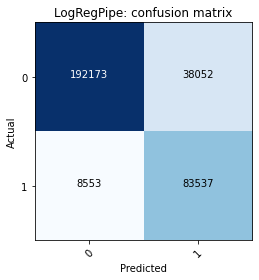

In [67]:
cm = confusion_matrix(y_test, lr_test_pred > pr_thresholds[ix])
plot_confusion_matrix(cm, classes=["0", "1"], model_name="LogRegPipe");

LogReg+Pipe: AUC_ROC = 0.919


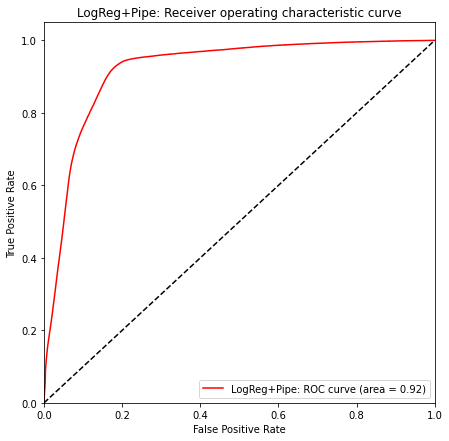

In [68]:
plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "LogReg+Pipe", color='r')
print("LogReg+Pipe: AUC_ROC = %.3f" % auc(fpr, tpr))

In [69]:
print(classification_report(y_test, lr_test_pred > pr_thresholds[ix]))

              precision    recall  f1-score   support

         0.0       0.96      0.83      0.89    230225
         1.0       0.69      0.91      0.78     92090

    accuracy                           0.86    322315
   macro avg       0.82      0.87      0.84    322315
weighted avg       0.88      0.86      0.86    322315



In [70]:
get_classification_report(y_train, lr_train_pred, y_test, lr_test_pred, pr_thresholds[ix])

TRAIN

              precision    recall  f1-score   support

         0.0       0.96      0.83      0.89    537192
         1.0       0.69      0.91      0.78    214876

    accuracy                           0.86    752068
   macro avg       0.82      0.87      0.84    752068
weighted avg       0.88      0.86      0.86    752068

TEST

              precision    recall  f1-score   support

         0.0       0.96      0.83      0.89    230225
         1.0       0.69      0.91      0.78     92090

    accuracy                           0.86    322315
   macro avg       0.82      0.87      0.84    322315
weighted avg       0.88      0.86      0.86    322315



In [71]:
# run_cv(lr_estimator, kfold_cv, X_train, y_train, model_name="Baseline");

### 3.2. Pipline XGBOOST

In [72]:
xgb_params = {"random_state": RANDOM_STATE,
                "n_estimators": 20,
                "max_depth": 7,
                "learning_rate": 0.05,
                "reg_lambda": 0.5,
                "reg_alpha": 0.5,
                "eval_metric": 'logloss'
             }

In [73]:
xgb_estimator = make_pipeline(
    feat_prep_pipeline,
    XGBClassifier(**xgb_params)
)

In [74]:
%%time
xgb_estimator.fit(X_train, y_train)

CPU times: user 9min 23s, sys: 7.58 s, total: 9min 31s
Wall time: 1min 30s


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['69', '239', '195',
                                                          'med_5', '99', '10',
                                                          '235', '247', '159',
                                                          '237', '18', '210',
                                                          '217', '223', '2',
                                                          '49', '228', 'id',
                                                          '238', '192',
                                                          'buy_time', '9',
                                                          '133', '214', '135',
                                                          '13', 'vas_id', '129',
                                                          '249', '7', ...])),
                                 ('featureunion',
                

In [75]:
xgb_test_pred = xgb_estimator.predict_proba(X_test)[:,1]
xgb_train_pred = xgb_estimator.predict_proba(X_train)[:,1]

In [76]:
fpr, tpr, roc_thresholds = roc_curve(y_test, xgb_test_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, xgb_test_pred)

In [77]:
beta = 1 
fscore = (1+beta**2)*(precision * recall) / (beta**2*precision + recall)
ix = np.nanargmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (pr_thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.488593, F-Score=0.897, Precision=0.879, Recall=0.915


Confusion matrix, without normalization
[[218672  11553]
 [  7921  84169]]


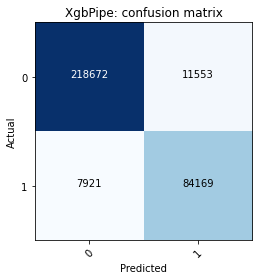

In [78]:
cm = confusion_matrix(y_test, xgb_test_pred > pr_thresholds[ix])
plot_confusion_matrix(cm, classes=["0", "1"], model_name="XgbPipe");

In [79]:
print(classification_report(y_test, xgb_test_pred > pr_thresholds[ix]))

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96    230225
         1.0       0.88      0.91      0.90     92090

    accuracy                           0.94    322315
   macro avg       0.92      0.93      0.93    322315
weighted avg       0.94      0.94      0.94    322315



In [80]:
# Модель не переобучилась, оценка на тесте высокая
get_classification_report(y_train, xgb_train_pred, y_test, xgb_test_pred, pr_thresholds[ix])

TRAIN

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96    537192
         1.0       0.88      0.91      0.90    214876

    accuracy                           0.94    752068
   macro avg       0.92      0.93      0.93    752068
weighted avg       0.94      0.94      0.94    752068

TEST

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96    230225
         1.0       0.88      0.91      0.90     92090

    accuracy                           0.94    322315
   macro avg       0.92      0.93      0.93    322315
weighted avg       0.94      0.94      0.94    322315



XGB+Pipe: AUC_ROC = 0.981


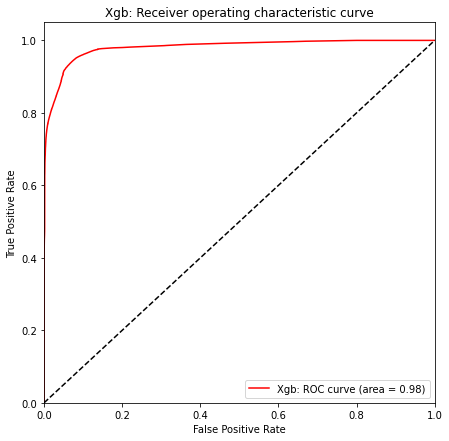

In [81]:
plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "Xgb", color='r')
print("XGB+Pipe: AUC_ROC = %.3f" % auc(fpr, tpr))

[k for k in xgb_estimator.get_params().keys()]

%time
param_grid = {
    "xgbclassifier__reg_alpha": [0.1, 0.5, 0.9], 
    "xgbclassifier__reg_lambda": [0.1, 0.5, 0.9]
                }

clf = GridSearchCV(xgb_estimator, param_grid)
clf.fit(X_train, y_train)

clf.best_params_

### 3.3. Pipeline CatBoos

In [82]:
X_train['vas_id'] = X_train['vas_id'].astype(int)
X_test['vas_id'] = X_test['vas_id'].astype(int)

In [83]:
catb_estimator = make_pipeline(
    feat_prep_pipeline,
    catboost.CatBoostClassifier(n_estimators=50, 
                                         max_depth=5, 
                                         l2_leaf_reg=5, 
#                                          cat_features=['id', 'vas_id'], 
                                         silent=True, 
                                         random_state=RANDOM_STATE)
    )

In [84]:
%%time
catb_estimator.fit(X_train, y_train)

CPU times: user 1min 34s, sys: 9.27 s, total: 1min 43s
Wall time: 30.2 s


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['69', '239', '195',
                                                          'med_5', '99', '10',
                                                          '235', '247', '159',
                                                          '237', '18', '210',
                                                          '217', '223', '2',
                                                          '49', '228', 'id',
                                                          '238', '192',
                                                          'buy_time', '9',
                                                          '133', '214', '135',
                                                          '13', 'vas_id', '129',
                                                          '249', '7', ...])),
                                 ('featureunion',
                

In [85]:
%%time
catb_test_pred = catb_estimator.predict_proba(X_test)[:,1]
catb_train_pred = catb_estimator.predict_proba(X_train)[:,1]

CPU times: user 29.7 s, sys: 9.93 s, total: 39.6 s
Wall time: 22.4 s


In [86]:
fpr, tpr, roc_thresholds = roc_curve(y_test, catb_test_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, catb_test_pred)

In [87]:
beta = 1 
fscore = (1+beta**2)*(precision * recall) / (beta**2*precision + recall)
ix = np.nanargmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (pr_thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.501798, F-Score=0.897, Precision=0.887, Recall=0.908


CatBoost: AUC_ROC = 0.982


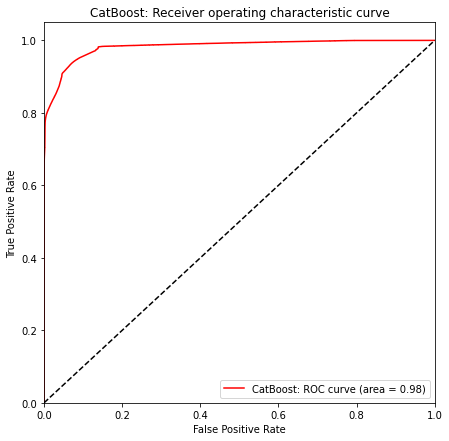

In [88]:
plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "CatBoost", color='r')
print("CatBoost: AUC_ROC = %.3f" % auc(fpr, tpr))

Confusion matrix, without normalization
[[219574  10651]
 [  8462  83628]]


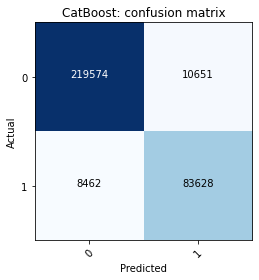

In [89]:
cm = confusion_matrix(y_test, catb_test_pred > pr_thresholds[ix])
plot_confusion_matrix(cm, classes=["0", "1"], model_name="CatBoost");

In [90]:
# Качество примерно такое же как в xgboost
get_classification_report(y_train, catb_train_pred, y_test, catb_test_pred, pr_thresholds[ix])

TRAIN

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96    537192
         1.0       0.89      0.91      0.90    214876

    accuracy                           0.94    752068
   macro avg       0.92      0.93      0.93    752068
weighted avg       0.94      0.94      0.94    752068

TEST

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96    230225
         1.0       0.89      0.91      0.90     92090

    accuracy                           0.94    322315
   macro avg       0.92      0.93      0.93    322315
weighted avg       0.94      0.94      0.94    322315



### 4.1. Применение на тестовом датасете

In [91]:
# Создаем объединенные столбцы в тестовом датасете
df_test['user_vas'] = df_test['id'].astype(str) + '_' + df_test['vas_id'].astype(str)
df_test['user_buytime'] = df_test['id'].astype(str) + '_' + df_test['buy_time'].astype(str)
df_test.head(3)

,id,vas_id,buy_time,user_vas,user_buytime
0,3130519,2.0,1548018000,3130519_2.0,3130519_1548018000
1,2000860,4.0,1548018000,2000860_4.0,2000860_1548018000
2,1099444,2.0,1546808400,1099444_2.0,1099444_1546808400


In [92]:
# В тестовом датасете есть дублирующие строки по одной и той же услуге с разным временем покупки
duplicateRowsDF = df_test[df_test.duplicated(['user_vas'])]
duplicateRowsDF.head(3)

,id,vas_id,buy_time,user_vas,user_buytime
1141,698739,6.0,1547413200,698739_6.0,698739_1547413200
2231,114110,4.0,1547413200,114110_4.0,114110_1547413200
3474,1782890,6.0,1547413200,1782890_6.0,1782890_1547413200


In [93]:
# !!!!!
df_test.loc[(df_test['id']==114110)]

,id,vas_id,buy_time,user_vas,user_buytime
2230,114110,4.0,1546808400,114110_4.0,114110_1546808400
2231,114110,4.0,1547413200,114110_4.0,114110_1547413200


In [94]:
%time
test_res = merge_dfs(df_test, data)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs


In [95]:
test_res.shape, test_res['id'].unique().shape

((71231, 259), (70152,))

In [96]:
test_res.drop(['user_buytime', 'user_vas'], axis=1, inplace=True)
test_res['year'] = test_res['date'].map(lambda x: x.year)
test_res['month'] = test_res['date'].map(lambda x: x.month)
test_res['day'] = test_res['date'].map(lambda x: x.day)
test_res.drop(['date'], axis=1, inplace=True)

In [97]:
# Добавляем медианные значения этих признаков в качестве фичей
test_res = test_res.merge(med_1, how='left', on='vas_id')
test_res = test_res.merge(med_3, how='left', on='vas_id')
test_res = test_res.merge(med_5, how='left', on='vas_id')
test_res = test_res.merge(med_207, how='left', on='vas_id')

In [98]:
# Удаляем из датасета признаки с околонулевой значимостью
test_res = test_res.drop(['89', '94', '12', '82','90','22','123','122','105', '109','142', '92', '161', '200',
                            '220', '189', '86', '120', '27', '176', '232', '121', '72', '91', '124', '212', '153',
                            '173', '197', '119', '93', '80', '78', '178', '175', '180', '163', '177', '57', '79', 
                            '118', '88', '17', '199', '216', '218', '221','155', '35', '83', '154', '16', '33', 
                            '85', '95', '31', '202', '179', '32', '81', '84', '139', 'year', '75', '23', '24', 
                            '87', '203','15'], axis=1)

In [99]:
test_res

,id,vas_id,buy_time,0,1,2,3,4,5,6,7,8,9,10,11,13,14,18,19,20,21,25,26,28,29,30,34,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,58,59,...,201,204,205,206,207,208,209,210,211,213,214,215,217,219,222,223,224,225,226,227,228,229,230,231,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,month,day,med_1,med_3,med_5,med_201
0,3130519,2.0,1548018000,-62.899971,-374.279114,-72.600784,-418.406799,-78.018250,-439.511780,17.81382,-31.176098,-6.78366,-30.006538,31.163919,-4.007526,-66.189125,-77.518112,-5.41746,-3.178521,-9.700815,-10.744164,-2.082209,0.200138,-0.351862,-0.214366,-0.211608,-2.659389,-0.700765,-92.026962,-2847.354492,-1091.679932,-1755.674561,-89.504288,-119.724358,-88.778687,-35.052525,-53.726162,-7.896282,-7.997875,-10.361439,-28.563688,-17.130283,-22.088985,-48.171711,-25.331295,-4.958702,-8.745251,-1.671324,-24.681646,-3.882665,...,-0.104665,0.039208,-0.334356,-0.008999,-11953.712891,10384.742188,0.377099,-30.716053,-61790.15625,-42051.167969,-9239.707031,-2.10805,0.377104,0.379228,-572669504.0,-58.544079,-4.405604e+08,-1.204418e+08,6.899333,-1.465191,-32.302380,-252.128983,-39.772491,-0.364694,-0.209468,-35.356506,-109.884567,-876.69104,-5.368281,-247.110703,-108.409744,-512.437317,-84.617981,-17.295406,-970.373840,-613.770813,-25.996269,-37.630447,-258.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0,1,20,-59.804111,-78.966797,-92.901787,-6846.600586
1,2000860,4.0,1548018000,-96.799973,100.290886,-110.740784,140.903198,-116.158249,119.798210,-16.08618,-65.076096,-6.78366,-30.006538,-2.736081,-4.007526,-66.189125,-77.518112,-5.41746,-3.178521,-13.940815,-10.744164,-2.082209,0.200138,-0.351862,-0.214366,-0.211608,-2.659389,-0.700765,-192.026962,-2941.477539,-1186.665283,-1754.812256,-89.504288,-119.724358,-89.412018,-24.352526,-65.059494,-7.896282,-7.997875,-10.717958,-28.571102,-4.130284,-9.088986,-10.171711,0.668705,-4.958702,-9.745251,-1.671324,-14.681646,-2.882665,...,0.895335,0.039208,0.665644,-0.008999,15960.798828,559624.750000,-0.622901,-30.716053,-61790.15625,-42051.167969,-9239.707031,-2.10805,-0.622896,-0.620772,-572669504.0,-58.544079,-4.405604e+08,-1.204418e+08,1.399332,-1.465191,-33.302380,-265.128998,-39.772491,-0.364694,-0.209468,-35.356506,-109.884567,-873.69104,-3.368281,-247.110703,-108.409744,-511.437317,-106.617981,-17.295406,-977.373840,-613.770813,-25.996269,-37.630447,-254.747726,-25.832888,-0.694429,-12.175933,-0.45614,0.0,1,20,-55.544113,-75.016800,-88.241791,-6357.891113
2,1099444,2.0,1546808400,-81.969971,-390.729126,-95.910789,-443.336792,-101.328247,-464.441803,-16.08618,-65.076096,-6.78366,-30.006538,-2.736081,-4.007526,-66.189125,-64.808113,-5.41746,-1.058521,-13.940815,-10.744164,-2.082209,-0.799862,-0.351862,-0.214366,-0.211608,-2.659389,-0.700765,407.973053,-2942.440430,-1186.765869,-1755.674561,-89.504288,-119.724358,-116.645355,-52.169193,-64.476158,-7.896282,-3.784615,-10.717958,-28.571102,51.869717,51.911015,25.828289,-21.331295,0.041298,-4.745251,-1.671324,-13.681646,-1.882665,...,-0.104665,0.039208,-0.334356,-0.008999,-12274.540039,-45175.257812,0.377099,-30.716053,-61790.15625,-42051.156250,-9239.707031,-2.10805,0.377104,0.379228,-572669504.0,-58.544079,1.065420e+09,-1.204418e+08,-6.100667,-1.465191,-33.302380,-266.128998,-39.772491,-0.364694,-0.209468,-35.356506,-109.884567,-876.69104,-5.368281,-247.110703,-108.409744,-512.437317,-106.617981,-17.295406,-977.373840,-613.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.45614,1.0,1,6,-59.804111,-78.966797,-92.901787,-6846.600586
3,1343255,5.0,1547413200,259.130035,-52.249111,245.189209,-104.856796,239.771759,-125.961792,-16.08618,-65.076096,-6.78366,-30.006538,-2.736081,-4.007526,289.740875,278.411896,-5.41746,-3.178521,-13.940815,-10.744164,-2.082209,0.200138,-0.351862,-0.214366,-0.211608,-2.659389,-0.700765,-192.026962,-2942.440430,-1186.765869,-1755.674561,-89.504288,-119.724358,39.537983,41.747475,-2.209494,-7.896282,-5.762134,-10.717958,-28.571102,-

In [100]:
preds = xgb_estimator.predict_proba(test_res)[:,1]

In [101]:
result = pd.concat([test_res['id'], test_res['vas_id'], test_res['buy_time'], pd.Series(preds)], axis=1)

In [102]:
# применить treshold = 0.49 как на трейне
result = result.rename(columns={0: 'target'})
result

,id,vas_id,buy_time,target
0,3130519,2.0,1548018000,0.181660
1,2000860,4.0,1548018000,0.408238
2,1099444,2.0,1546808400,0.181660
3,1343255,5.0,1547413200,0.181660
4,1277040,2.0,1546808400,0.181660
...,...,...,...,...
71226,2502453,5.0,1548018000,0.181660
71227,1693213,2.0,1548018000,0.181660
71228,1891350,2.0,1548018000,0.181660
71229,2437172,2.0,1548018000,0.181660


In [103]:
result.shape

(71231, 4)

In [104]:
# Сохранение в csv
result.to_csv('./data/result.csv', encoding="utf-8-sig", sep=';', index=False)

### 4.2. Сохранение финальной модели

In [105]:
with open('./models/xgb_estimator.pickle', 'wb') as file:
          pickle.dump(xgb_estimator, file)

In [106]:
with open('./models/xgb_estimator.pickle', 'rb') as model_file:
    model = pickle.load(model_file)
        
preds = model.predict_proba(test_res)[:,1]
result = pd.concat([test_res['id'], test_res['vas_id'], test_res['buy_time'], pd.Series(preds)], axis=1)
result = result.rename(columns={0: 'target'})

# Сохранение в csv
result.to_csv('./data/result.csv', encoding="utf-8-sig", sep=';', index=False)

### 4.3. Применение на тестовом датасете без балансировки

In [107]:
train_res = merge_dfs(df_train, data)

train_res.drop(['user_buytime', 'user_vas'], axis=1, inplace=True)
train_res['year'] = train_res['date'].map(lambda x: x.year)
train_res['month'] = train_res['date'].map(lambda x: x.month)
train_res['day'] = train_res['date'].map(lambda x: x.day)
train_res.drop(['date'], axis=1, inplace=True)

# Добавляем медианные значения этих признаков в качестве фичей
train_res = train_res.merge(med_1, how='left', on='vas_id')
train_res = train_res.merge(med_3, how='left', on='vas_id')
train_res = train_res.merge(med_5, how='left', on='vas_id')
train_res = train_res.merge(med_207, how='left', on='vas_id')

# Удаляем из датасета признаки с околонулевой значимостью
train_res = train_res.drop(['89', '94', '12', '82','90','22','123','122','105', '109','142', '92', '161', '200',
                            '220', '189', '86', '120', '27', '176', '232', '121', '72', '91', '124', '212', '153',
                            '173', '197', '119', '93', '80', '78', '178', '175', '180', '163', '177', '57', '79', 
                            '118', '88', '17', '199', '216', '218', '221','155', '35', '83', '154', '16', '33', 
                            '85', '95', '31', '202', '179', '32', '81', '84', '139', 'year', '75', '23', '24', 
                            '87', '203','15'], axis=1)

X = train_res.drop(columns='target')
y = train_res['target']

with open("./models/xgb_estimator.pickle", 'rb') as model_file:
    model = pickle.load(model_file)

train_preds = model.predict_proba(X)[:,1]

In [108]:
fpr, tpr, roc_thresholds = roc_curve(y, train_preds)
precision, recall, pr_thresholds = precision_recall_curve(y, train_preds)

In [109]:
beta = 1 
fscore = (1+beta**2)*(precision * recall) / (beta**2*precision + recall)
ix = np.nanargmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (pr_thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.451879, F-Score=0.560, Precision=0.467, Recall=0.699


Confusion matrix, without normalization
[[721136  46281]
 [ 17478  40509]]


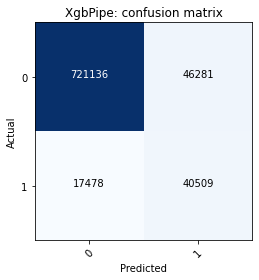

In [110]:
cm = confusion_matrix(y, train_preds > pr_thresholds[ix])
plot_confusion_matrix(cm, classes=["0", "1"], model_name="XgbPipe");

In [111]:
print(classification_report(y, train_preds > pr_thresholds[ix]))

              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96    767417
         1.0       0.47      0.70      0.56     57987

    accuracy                           0.92    825404
   macro avg       0.72      0.82      0.76    825404
weighted avg       0.94      0.92      0.93    825404



XGB+Pipe: AUC_ROC = 0.931


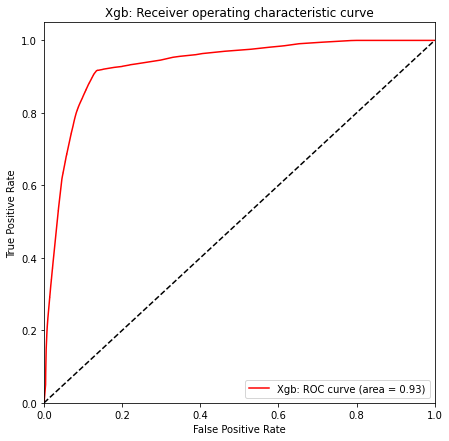

In [112]:
plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "Xgb", color='r')
print("XGB+Pipe: AUC_ROC = %.3f" % auc(fpr, tpr))